# Show that the muon and proton detection effieciencies are decoupled

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
8211 selected CC1p events overlay


# What is the acceptance as a function of $p_p$ and $\theta_p$ in different bins of $p_\mu$ and $\theta_\mu$

In [97]:
def sample_in_xy_bin(sample,xmin,xmax,ymin,ymax,xvar,yvar):
    return sample[(xmin<sample[xvar])&(sample[xvar]<xmax)&(ymin<sample[yvar])&(sample[yvar]<ymax)]
def sample_in_muon_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max):
    return sample_in_xy_bin(sample,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max,xvar='truth_Pmu',yvar='truth_Pmu_cos_theta')
def sample_in_proton_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max):
    return sample_in_xy_bin(sample,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max,xvar='truth_Pp',yvar='truth_Pp_cos_theta')

In [122]:
large_bins_Pmu_min = np.array([0,0.45])
large_bins_Pmu_max = np.array([large_bins_Pmu_min[1],2])
large_bins_Pmu_centers = 0.5*(large_bins_Pmu_min+large_bins_Pmu_max)
large_bins_Pmu_cos_theta_min = np.array([-0.2,0.5])
large_bins_Pmu_cos_theta_max = np.array([large_bins_Pmu_cos_theta_min[1],1])
large_bins_Pmu_cos_theta_centers = 0.5*(large_bins_Pmu_cos_theta_min+large_bins_Pmu_cos_theta_max)

hCC1p_muon_bins = np.zeros((2,2))

# proton acceptance parameters
NpBins = 5
Pp_bins = linspace(0.3,1.,NpBins)
Pp_cos_theta_bins = linspace(0.2,1,NpBins)
Pp_xcenters,Pp_cos_theta_ycenters = 0.5*(Pp_bins[1:]+Pp_bins[:-1]),0.5*(Pp_cos_theta_bins[1:]+Pp_cos_theta_bins[:-1])
nx_p,ny_p = len(Pp_bins)-1,len(Pp_cos_theta_bins)-1

In [123]:
h_p_eff,h_p_eff_err = dict(),dict()
h_p_gen,h_p_acc = dict(),dict()
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        selected_CC1p_muon_bin = sample_in_muon_bin(selected_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
        genie_CC1p_muon_bin = sample_in_muon_bin(genie_CC1p,Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)        

        hCC1p_muon_bins[iPmu][iPmu_cos_theta] = len(selected_CC1p_muon_bin)

        
        # now check the proton acceptance in this muon-kinematics bin
        hgen,hacc,heff,heff_err = np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p)),np.zeros((nx_p,ny_p))
        total_len_acc_proton_bin = 0
        for iPp in range(nx_p):
            Pp_min,Pp_max = Pp_bins[iPp],Pp_bins[iPp+1]    
            for iPp_cos_theta in range(ny_p):
                Pp_cos_theta_min,Pp_cos_theta_max = Pp_cos_theta_bins[iPp_cos_theta],Pp_cos_theta_bins[iPp_cos_theta+1]        
                # efficiency
                gen_proton_bin = sample_in_proton_bin(genie_CC1p_muon_bin,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)            
                hgen[iPp][iPp_cos_theta] = len(gen_proton_bin)        
                
                acc_proton_bin = sample_in_proton_bin(selected_CC1p_muon_bin,Pp_min,Pp_max,Pp_cos_theta_min,Pp_cos_theta_max)
                hacc[iPp][iPp_cos_theta] = len(acc_proton_bin)        
                heff[iPp][iPp_cos_theta] = float(hacc[iPp][iPp_cos_theta])/(hgen[iPp][iPp_cos_theta] if hgen[iPp][iPp_cos_theta]>0 else 1)
                heff_err[iPp][iPp_cos_theta] = heff[iPp][iPp_cos_theta]*np.sqrt( (1./hgen[iPp][iPp_cos_theta] 
                                                                                  if hgen[iPp][iPp_cos_theta] else 0)                                                                
                                                                                + (1./hacc[iPp][iPp_cos_theta] 
                                                                                   if hacc[iPp][iPp_cos_theta] else 0) )
        h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = hgen.T
        h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = hacc.T

        h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = heff.T
        h_p_eff_err['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)] = heff_err.T
print 'done.'

done.


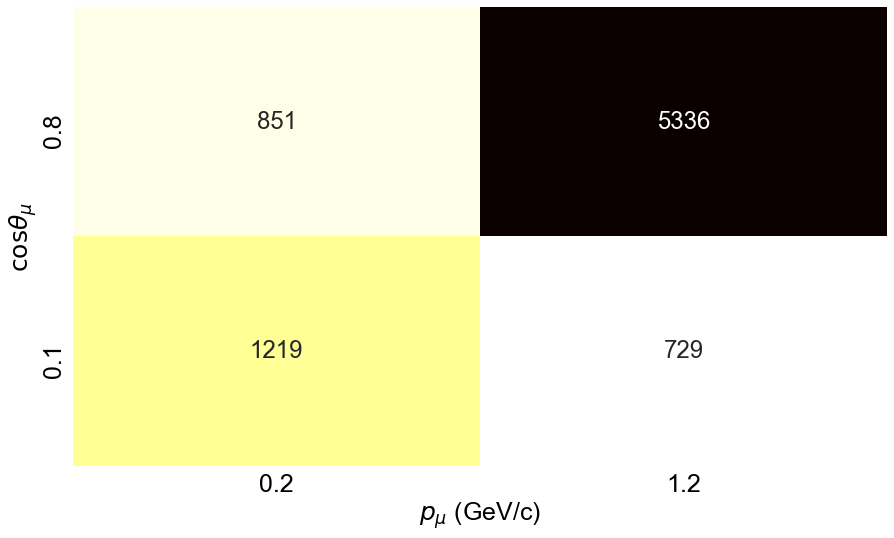

In [124]:
fig = plt.figure(figsize=(12.944,8))
ax = fig.add_subplot(1,1,1)
sns.set(font_scale=2);
sns.heatmap(hCC1p_muon_bins.T.astype(np.int),annot=True,cmap='hot_r',fmt="d"         
            ,xticklabels=["%.1f"%tick for tick in large_bins_Pmu_centers]
            ,yticklabels=["%.1f"%tick for tick in large_bins_Pmu_cos_theta_centers]
            ,cbar=False)
set_axes(ax,r'$p_\mu$ (GeV/c)',r'$\cos\theta_\mu$')
ax.invert_yaxis()
plt.tight_layout()

## efficiency

Integral: 1.09464009502
Integral: 1.05529759495
Integral: 1.39201819508
Integral: 1.29122507161


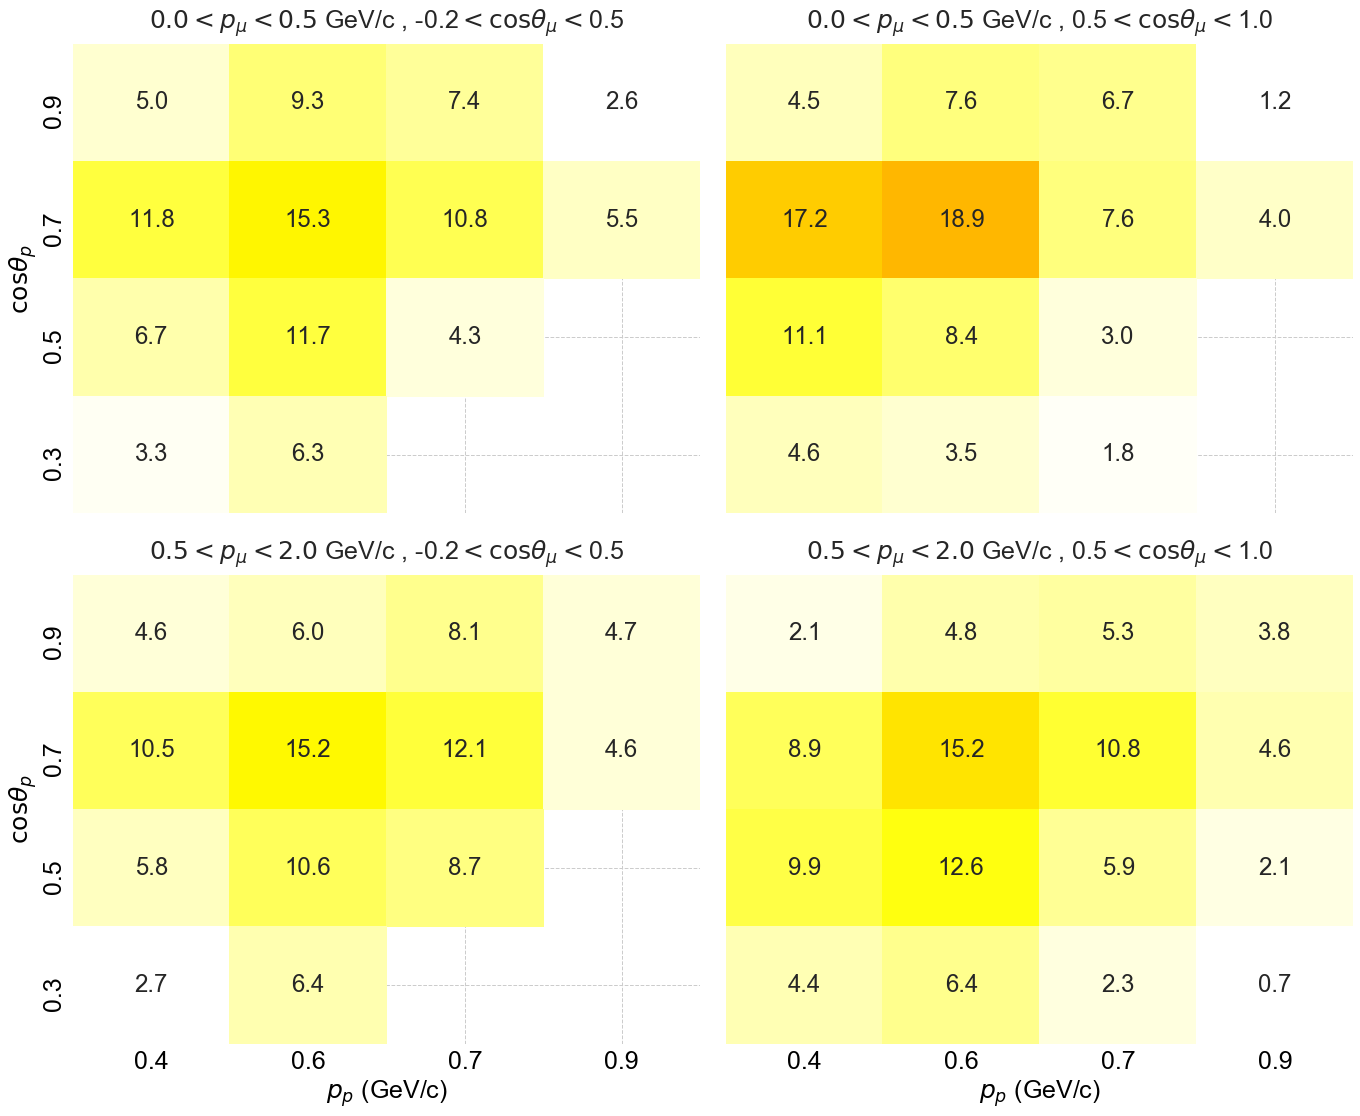

In [125]:
fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_eff['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        print 'Integral:',Integral
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=50
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()

## generated and accepted

Integral: 13863.0
Integral: 8007.0
Integral: 6243.0
Integral: 47201.0


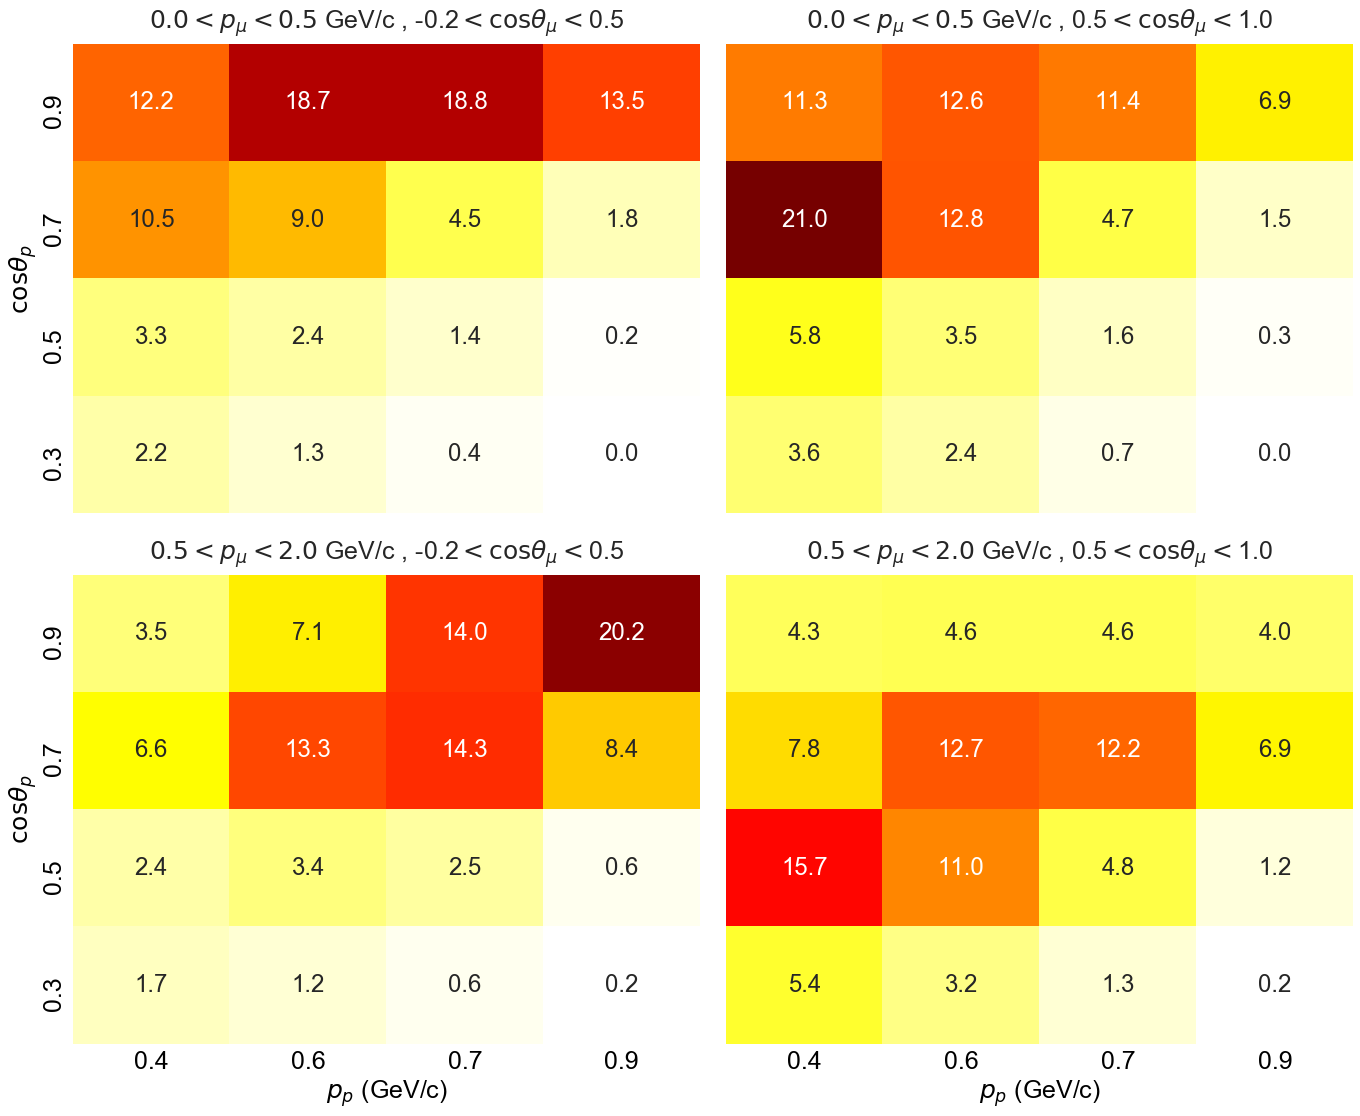

In [115]:
fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_gen['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        print 'Integral:',Integral
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=25
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()

fig = plt.figure(figsize=(19.416,16))
sns.set_style('white')
for iPmu,(Pmu_min,Pmu_max) in enumerate(zip(large_bins_Pmu_min,large_bins_Pmu_max)):
    for iPmu_cos_theta,(Pmu_cos_theta_min,Pmu_cos_theta_max) in enumerate(zip(large_bins_Pmu_cos_theta_min,large_bins_Pmu_cos_theta_max)):
        ax = fig.add_subplot(2,2,2*iPmu+iPmu_cos_theta+1)
        histo = h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)]
        Integral = np.sum(h_p_acc['iPmu %d iPmu_cos_theta %d'%(iPmu,iPmu_cos_theta)])
        histo = histo/Integral
        histo[histo <= 0] = None
        sns.heatmap(100*histo,annot=True,cmap='hot_r',fmt=".1f",vmin=None,vmax=25
            ,xticklabels=["%.1f"%tick for tick in Pp_xcenters]
            ,yticklabels=["%.1f"%tick for tick in Pp_cos_theta_ycenters]
            ,cbar=False)
        set_axes(ax,do_add_grid=True,alpha_grid=1
                 ,x_label='' if iPmu==0 else  r'$p_p$ (GeV/c)'
                 ,remove_ticks_x=True if iPmu==0 else False
                 ,y_label=''  if iPmu_cos_theta==1 or iPmu_cos_theta==3 else  r'$\cos\theta_p$'
                 ,remove_ticks_y=True if iPmu_cos_theta==1 or iPmu_cos_theta==3 else False
                 ,title=r'$%.1f<p_\mu<%.1f$ GeV/c , %s$<\cos\theta_\mu<$%s'%(Pmu_min,Pmu_max,Pmu_cos_theta_min,Pmu_cos_theta_max)
                 )
        ax.invert_yaxis()
plt.tight_layout()